In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import math
import torch.nn.functional as F
from tqdm import tqdm

# UNet for MNIST

In [2]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv_block(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)

        return down, pool

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.dconv1 = DownSampling(in_channels, 64)
        self.dconv2 = DownSampling(64, 128)
        self.dconv3 = DownSampling(128, 256)
        self.dconv4 = DownSampling(256, 512)

        self.bottle_neck = DoubleConvolution(512, 1024)

        self.uconv1 = UpSampling(1024, 512)
        self.uconv2 = UpSampling(512, 256)
        self.uconv3 = UpSampling(256, 128)
        self.uconv4 = UpSampling(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1,p1 = self.dconv1(x)
        d2,p2 = self.dconv2(p1)
        d3,p3 = self.dconv3(p2)
        d4,p4 = self.dconv4(p3)

        b = self.bottle_neck(p4)

        u1 = self.uconv1(b, d4)
        u2 = self.uconv2(u1, d3)
        u3 = self.uconv3(u2, d2)
        u4 = self.uconv4(u3, d1)

        out = self.out(u4)
        return out

# Linear noise scheduler

In [3]:
class LinearNoiseScheduler:
    def __init__(self, device, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        self.timesteps = timesteps

        # Start and end are the beta values for the linear noise schedule that we linearly interpolate between (hence linear scheduler)
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas # Equation 1
        self.alpha_hat = torch.cumprod(self.alphas, dim=0).to(device)  # Equation 2

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor):
        epsilon = torch.randn_like(x0) # Input: x_0 - it returns the same size/shape as the input tensor (i.e. image)

        # gather alpha_bars for each sample in the batch
        alpha_bar_t = self.alpha_hat[t].view(-1, 1, 1, 1).to(x0.device)
        first_term = torch.sqrt(alpha_bar_t) * x0
        second_term = torch.sqrt(1 - alpha_bar_t) * epsilon
        return first_term + second_term, second_term # Equation 3

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
model = UNet(in_channels=1, num_classes=1)

noise_scheduler = LinearNoiseScheduler(device=device)

In [6]:
model(torch.randn(1, 1, 32, 32))  # Test the model with a random input
model(F.pad(torch.randn(1, 1, 28, 28), pad=(2, 2, 2, 2)))  # The image must be divisible by 2^4 = 16 because we have 4 downsampling layers

tensor([[[[0.0906, 0.0894, 0.0901,  ..., 0.0926, 0.0894, 0.0903],
          [0.0887, 0.0915, 0.0914,  ..., 0.0939, 0.0934, 0.0917],
          [0.0919, 0.0908, 0.0937,  ..., 0.0943, 0.0962, 0.0963],
          ...,
          [0.0921, 0.0933, 0.0885,  ..., 0.1032, 0.1018, 0.0954],
          [0.0922, 0.0959, 0.0949,  ..., 0.0960, 0.0981, 0.0926],
          [0.0902, 0.0948, 0.0930,  ..., 0.0923, 0.0941, 0.0940]]]],
       grad_fn=<ConvolutionBackward0>)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean & std
])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train on MNIST dataset and add noise

Epoch 1/30: 100%|██████████| 938/938 [00:53<00:00, 17.70it/s, loss=0]


Epoch 1 - Loss: 0.0000


Epoch 2/30: 100%|██████████| 938/938 [00:52<00:00, 18.03it/s, loss=0]


Epoch 2 - Loss: 0.0000


Epoch 3/30: 100%|██████████| 938/938 [00:50<00:00, 18.47it/s, loss=0]


Epoch 3 - Loss: 0.0000


Epoch 4/30: 100%|██████████| 938/938 [00:51<00:00, 18.11it/s, loss=0]


Epoch 4 - Loss: 0.0000


Epoch 5/30: 100%|██████████| 938/938 [00:51<00:00, 18.25it/s, loss=0]


Epoch 5 - Loss: 0.0000


Epoch 6/30: 100%|██████████| 938/938 [00:51<00:00, 18.12it/s, loss=0]


Epoch 6 - Loss: 0.0000


Epoch 7/30: 100%|██████████| 938/938 [00:50<00:00, 18.57it/s, loss=0]


Epoch 7 - Loss: 0.0000


Epoch 8/30: 100%|██████████| 938/938 [00:50<00:00, 18.44it/s, loss=0]


Epoch 8 - Loss: 0.0000


Epoch 9/30: 100%|██████████| 938/938 [00:51<00:00, 18.36it/s, loss=0]


Epoch 9 - Loss: 0.0000


Epoch 10/30: 100%|██████████| 938/938 [00:50<00:00, 18.42it/s, loss=0]


Epoch 10 - Loss: 0.0000


Epoch 11/30: 100%|██████████| 938/938 [00:50<00:00, 18.52it/s, loss=0]


Epoch 11 - Loss: 0.0000


Epoch 12/30: 100%|██████████| 938/938 [00:51<00:00, 18.39it/s, loss=0]


Epoch 12 - Loss: 0.0000


Epoch 13/30: 100%|██████████| 938/938 [00:54<00:00, 17.34it/s, loss=0]


Epoch 13 - Loss: 0.0000


Epoch 14/30: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s, loss=0]


Epoch 14 - Loss: 0.0000


Epoch 15/30: 100%|██████████| 938/938 [00:51<00:00, 18.18it/s, loss=0]


Epoch 15 - Loss: 0.0000


Epoch 16/30: 100%|██████████| 938/938 [00:51<00:00, 18.10it/s, loss=0]


Epoch 16 - Loss: 0.0000


Epoch 17/30: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s, loss=0]


Epoch 17 - Loss: 0.0000


Epoch 18/30: 100%|██████████| 938/938 [00:54<00:00, 17.07it/s, loss=0]


Epoch 18 - Loss: 0.0000


Epoch 19/30: 100%|██████████| 938/938 [00:58<00:00, 16.17it/s, loss=0]


Epoch 19 - Loss: 0.0000


Epoch 20/30: 100%|██████████| 938/938 [00:53<00:00, 17.47it/s, loss=0]


Epoch 20 - Loss: 0.0000


Epoch 21/30: 100%|██████████| 938/938 [00:54<00:00, 17.17it/s, loss=0]


Epoch 21 - Loss: 0.0000


Epoch 22/30: 100%|██████████| 938/938 [00:53<00:00, 17.62it/s, loss=0]


Epoch 22 - Loss: 0.0000


Epoch 23/30: 100%|██████████| 938/938 [00:53<00:00, 17.53it/s, loss=0]


Epoch 23 - Loss: 0.0000


Epoch 24/30: 100%|██████████| 938/938 [00:53<00:00, 17.43it/s, loss=0]


Epoch 24 - Loss: 0.0000


Epoch 25/30: 100%|██████████| 938/938 [00:58<00:00, 15.93it/s, loss=0]


Epoch 25 - Loss: 0.0000


Epoch 26/30: 100%|██████████| 938/938 [00:53<00:00, 17.65it/s, loss=0]


Epoch 26 - Loss: 0.0000


Epoch 27/30: 100%|██████████| 938/938 [00:52<00:00, 17.94it/s, loss=0]


Epoch 27 - Loss: 0.0000


Epoch 28/30: 100%|██████████| 938/938 [00:53<00:00, 17.60it/s, loss=0]


Epoch 28 - Loss: 0.0000


Epoch 29/30: 100%|██████████| 938/938 [00:52<00:00, 17.91it/s, loss=0]


Epoch 29 - Loss: 0.0000


Epoch 30/30: 100%|██████████| 938/938 [00:51<00:00, 18.06it/s, loss=0]


Epoch 30 - Loss: 0.0000


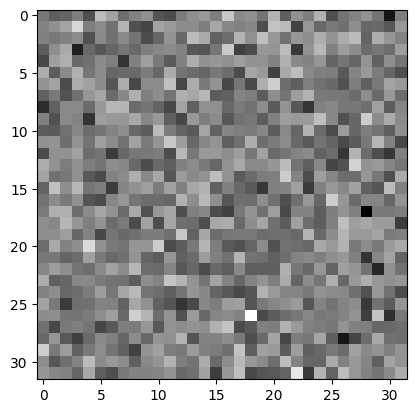

In [8]:
lr = 1e-4
epochs = 5
batch_size = 64

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

model.train()

for epoch in range(epochs):
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_of_imgs, _ in pbar:
        batch_of_imgs = batch_of_imgs.to(device)  # Shape: [B, 1, 28, 28]

        # Pad to 32x32 to work with 4 downsamplings
        batch_of_imgs = F.pad(batch_of_imgs, pad=(2, 2, 2, 2))

        # Sample random timesteps
        timesteps = torch.randint(0, noise_scheduler.timesteps, (batch_of_imgs.size(0),), device=device)

        # Add noise and get the actual noise
        noisy_img, noise_to_predict = noise_scheduler.add_noise(batch_of_imgs, timesteps)

        # Plot a single noisy image
        plt.imshow(noisy_img[0].cpu().detach().numpy().squeeze(), cmap='gray')

        # Predict noise
        pred_noise = model(noisy_img)

        # Compute loss
        loss = loss_fn(pred_noise, noise_to_predict)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / (pbar.n + 1e-8))

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader):.4f}")

In [9]:
# Save model
torch.save(model.state_dict(), "unet_denoiser_mnist.pth")

Test Loss: -0.0000


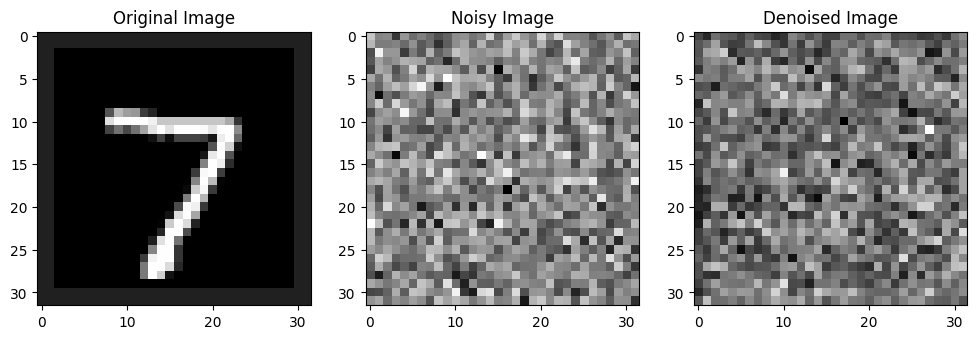

In [10]:
# Load an image from MNIST, then add noise, and then run the model to denoise it
model.eval()
with torch.no_grad():
    test_img, _ = next(iter(test_loader))
    test_img = test_img[0].unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]
    test_img = F.pad(test_img, pad=(2, 2, 2, 2))  # Pad to 32x32

    # Sample random timesteps
    timesteps = torch.randint(0, noise_scheduler.timesteps, (test_img.size(0),), device=device)

    # Add noise and get the actual noise
    noisy_test_img, noise_to_predict = noise_scheduler.add_noise(test_img, timesteps)

    # Predict noise
    pred_noise = model(noisy_test_img)

    # Compute loss
    loss = loss_fn(pred_noise, noise_to_predict)
    print(f"Test Loss: {loss.item():.4f}")

    # Plot original image, noisy image and denoised image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_img[0].cpu().detach().numpy().squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy_test_img[0].cpu().detach().numpy().squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(pred_noise[0].cpu().detach().numpy().squeeze(), cmap='gray')